In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import os
import json
from typing import Tuple
from tqdm import tqdm
from model_analysis.model_utils import *
from sklearn.metrics import mean_absolute_error

sns.set(rc={"figure.figsize": (20, 10)})


In [2]:
PATH_TO_DATA = "analysis/data/"
REPETITIONS = 10
MODELS_TO_EVALUATE = MODELS.keys()

In [3]:
def df_to_train_data(df: pd.DataFrame) -> Tuple[np.array, np.array]:
    return df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), df["rejeicao"]

def run_paredoes(index: int) -> pd.DataFrame:
    # Treinando em n-1 paredões para predizer o n-ésimo
    paredoes_df = pd.DataFrame()
    paredoes = len(os.listdir(PATH_TO_DATA)) + 1

    for model in tqdm(MODELS_TO_EVALUATE, desc="- Modelos analisados"):
        params = PARAMETERS[model]
        regressor_model = MODELS[model]
        # Using all features
        features = COLUMNS

        for paredao in range(1, paredoes):
            regressor = regressor_model(**params)
            
            train_df, test_df = get_train_test(paredao, features, normalize=NORMALIZE[model], data_path=PATH_TO_DATA)
            
            x_train, y_train = df_to_train_data(train_df)
            x_test, y_test = df_to_train_data(test_df)

            y_train, y_test = np.ravel(y_train), np.ravel(y_test)

            regressor.fit(x_train, y_train)
            prediction = regressor.predict(x_test)

            mae = mean_absolute_error(y_test, prediction)
            
            test_df["predicao"] = prediction
            
            pred_elimination, pred_pct = test_df.sort_values(by="predicao", ascending=False)[["nome", "predicao"]].iloc[0] 
            true_elimination, true_pct = test_df.sort_values(by="rejeicao", ascending=False)[["nome", "rejeicao"]].iloc[0]
            
            # renaming for consistence
            model_name = "ensamble1" if model == "ada_boost" else model 

            paredoes_df = paredoes_df.append(
                {
                    "repeticao": index,
                    "paredao": paredao,
                    "eliminado": true_elimination,
                    "rejeicao": true_pct,
                    "mae": mae,
                    "model": model_name,
                    "pred": pred_elimination,
                    "pred_pct": pred_pct
                },
                ignore_index=True
            )

    
    return pd.DataFrame(paredoes_df)

In [4]:
paredoes_analysis_df = run_paredoes(0)
for index in range(1, REPETITIONS): paredoes_analysis_df = paredoes_analysis_df.append(run_paredoes(index), ignore_index=True)

- Modelos analisados: 100%|██████████| 11/11 [00:20<00:00,  1.90s/it]


In [5]:
paredoes_analysis_df.head()

,eliminado,mae,model,paredao,pred,pred_pct,rejeicao,repeticao
0,lucas_chumbo,0.286778,linear_regression,1.0,lucas_chumbo,0.975834,0.7594,0.0
1,petrix,0.128308,linear_regression,2.0,petrix,0.453233,0.8027,0.0
2,hadson,0.112210,linear_regression,3.0,hadson,0.647271,0.7971,0.0
3,lucas,0.173664,linear_regression,4.0,lucas,0.519301,0.6262,0.0
4,bianca_andrade,0.221786,linear_regression,5.0,felipe_prior,0.583902,0.5309,0.0


# Contagem de acertos

In [6]:
paredoes_analysis_df["mean_absolute_error"] = abs(paredoes_analysis_df["rejeicao"] - paredoes_analysis_df["pred_pct"])
paredoes_analysis_df["correct"] = paredoes_analysis_df["eliminado"] == paredoes_analysis_df["pred"]

In [7]:
paredoes_analysis_df[paredoes_analysis_df["repeticao"] == 0]

,eliminado,mae,model,paredao,pred,pred_pct,rejeicao,repeticao,mean_absolute_error,correct
0,lucas_chumbo,0.286778,linear_regression,1.0,lucas_chumbo,0.975834,0.7594,0.0,0.216434,True
1,petrix,0.128308,linear_regression,2.0,petrix,0.453233,0.8027,0.0,0.349467,True
2,hadson,0.112210,linear_regression,3.0,hadson,0.647271,0.7971,0.0,0.149829,True
3,lucas,0.173664,linear_regression,4.0,lucas,0.519301,0.6262,0.0,0.106899,True
4,bianca_andrade,0.221786,linear_regression,5.0,felipe_prior,0.583902,0.5309,0.0,0.053002,False
...,...,...,...,...,...,...,...,...,...,...
182,flayslene,0.076326,ensamble2,13.0,flayslene,0.511351,0.6300,0.0,0.118649,True
183,gizelly_bicalho,0.135378,ensamble2,14.0,babu,0.514686,0.5479,0.0,0.033214,False
184,ivy,0.170096,ensamble2,15.0,ivy,0.573894,0.7417,0.0,0.167806,True
185,mari,0.073510,ensamble2,16.0,mari,0.438011,0.5416,0.0,0.103589,True


In [8]:
paredoes_analysis_df.to_csv("paredoes.csv")

In [9]:
resultados_medios = paredoes_analysis_df.groupby(["model", "paredao"]).mean()
resultados_medios["average_hits"] = paredoes_analysis_df[["model", "paredao", "correct"]].groupby(["model", "paredao"]).sum().values
resultados_medios.drop(["repeticao", "rejeicao"], axis=1, inplace=True)
resultados_medios.reset_index(inplace=True)


In [10]:
resultados_medios

,model,paredao,mae,pred_pct,mean_absolute_error,correct,average_hits
0,elastic_net,1.0,0.196071,0.394001,0.365399,1.0,10
1,elastic_net,2.0,0.270777,0.405784,0.396916,1.0,10
2,elastic_net,3.0,0.283029,0.326146,0.470954,1.0,10
3,elastic_net,4.0,0.210523,0.406869,0.219331,1.0,10
4,elastic_net,5.0,0.133998,0.356561,0.174339,0.0,0
...,...,...,...,...,...,...,...
182,svr,13.0,0.063590,0.582700,0.047300,1.0,10
183,svr,14.0,0.143678,0.539241,0.008659,0.0,0
184,svr,15.0,0.140695,0.670177,0.071523,1.0,10
185,svr,16.0,0.088815,0.471660,0.069940,1.0,10


In [11]:
acertos_medios = resultados_medios[["model", "average_hits"]].groupby("model").sum()
acertos_medios /= REPETITIONS

In [12]:
acertos_medios.sort_values(by="average_hits", ascending=False)

,average_hits
model,
ensamble2,15.0
svr,14.0
sgd,13.1
ensamble3,13.0
ridge,13.0
random_forest,12.2
linear_regression,12.0
ensamble1,11.1
knn,11.0


In [13]:
acertos_medios.sort_values(by="average_hits", inplace=True)

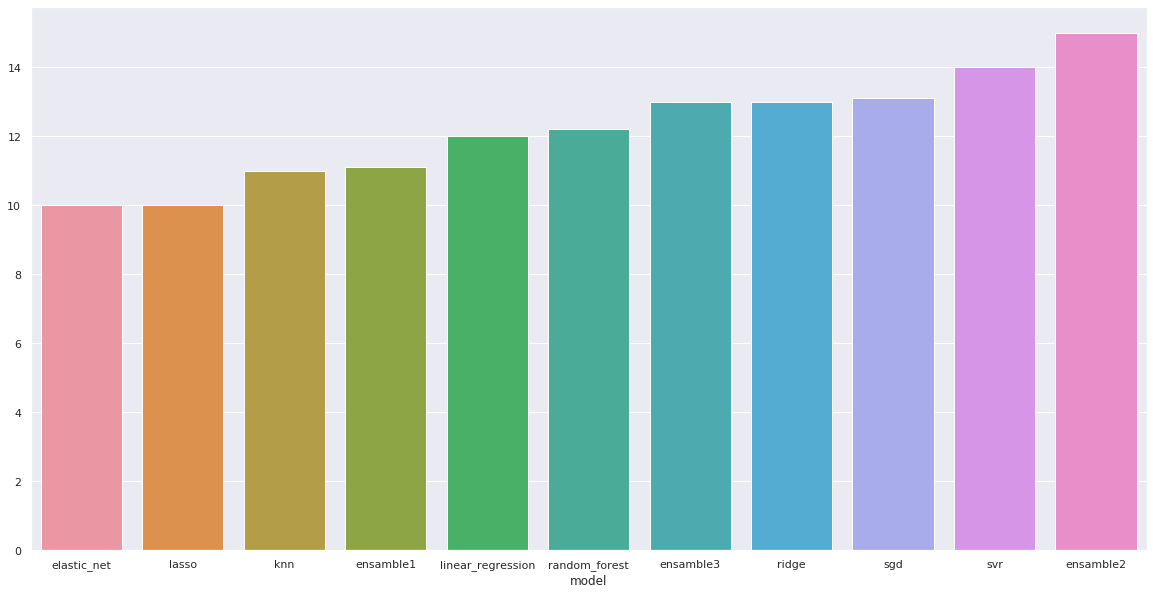

In [14]:
sns.barplot(x=acertos_medios.index, y=acertos_medios["average_hits"].values)

# Análise de erro absoluto por paredão

In [15]:
resultados_medios.sort_values(by="paredao", inplace=True)
erro_df = resultados_medios.set_index("paredao").pivot(columns="model")


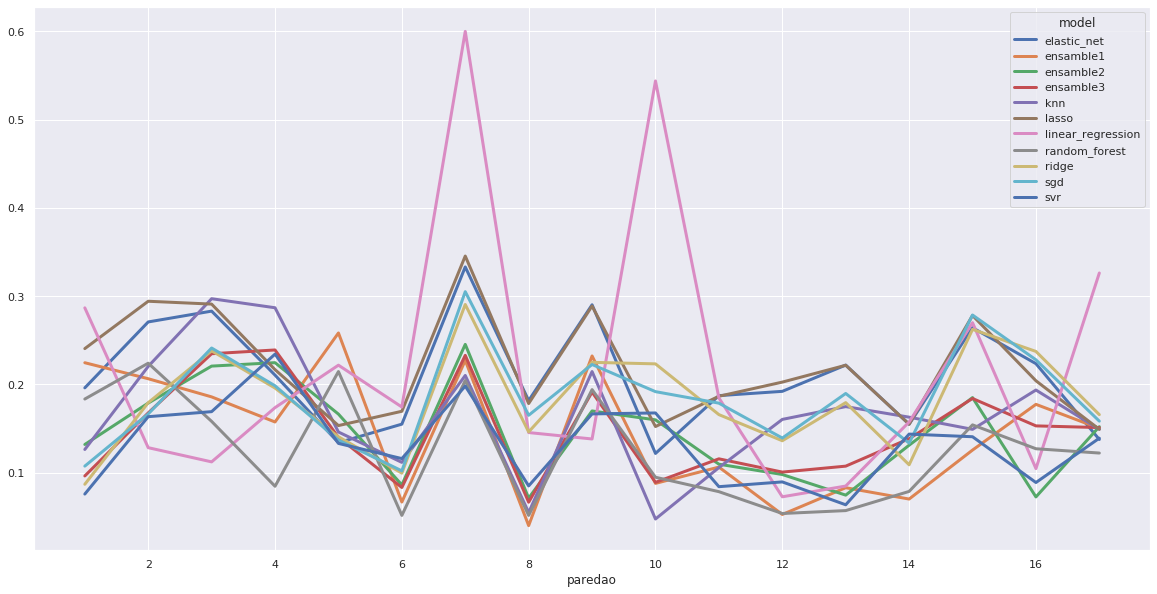

In [16]:
erro_df["mae"].plot(linewidth=3)

# Acertos em cada paredão

In [17]:
paredoes_analysis_df.head()

,eliminado,mae,model,paredao,pred,pred_pct,rejeicao,repeticao,mean_absolute_error,correct
0,lucas_chumbo,0.286778,linear_regression,1.0,lucas_chumbo,0.975834,0.7594,0.0,0.216434,True
1,petrix,0.128308,linear_regression,2.0,petrix,0.453233,0.8027,0.0,0.349467,True
2,hadson,0.112210,linear_regression,3.0,hadson,0.647271,0.7971,0.0,0.149829,True
3,lucas,0.173664,linear_regression,4.0,lucas,0.519301,0.6262,0.0,0.106899,True
4,bianca_andrade,0.221786,linear_regression,5.0,felipe_prior,0.583902,0.5309,0.0,0.053002,False


In [18]:
paredoes_analysis_df["paredao"] = paredoes_analysis_df["paredao"].astype(int)

In [19]:
paredoes_df = paredoes_analysis_df[["paredao", "model", "correct"]].groupby(["paredao", "model"]).sum()

In [20]:
paredoes_df.reset_index(inplace=True)
paredoes_df = paredoes_df.groupby("paredao").mean()

In [21]:
paredoes_df

,correct
paredao,
1,10.000000
2,9.818182
3,9.090909
4,8.636364
5,0.090909
6,10.000000
7,8.090909
8,8.454545
9,9.818182


In [22]:
paredoes_df = paredoes_df.groupby("paredao").mean()
paredoes_df.sort_index(inplace=True, ascending=False)

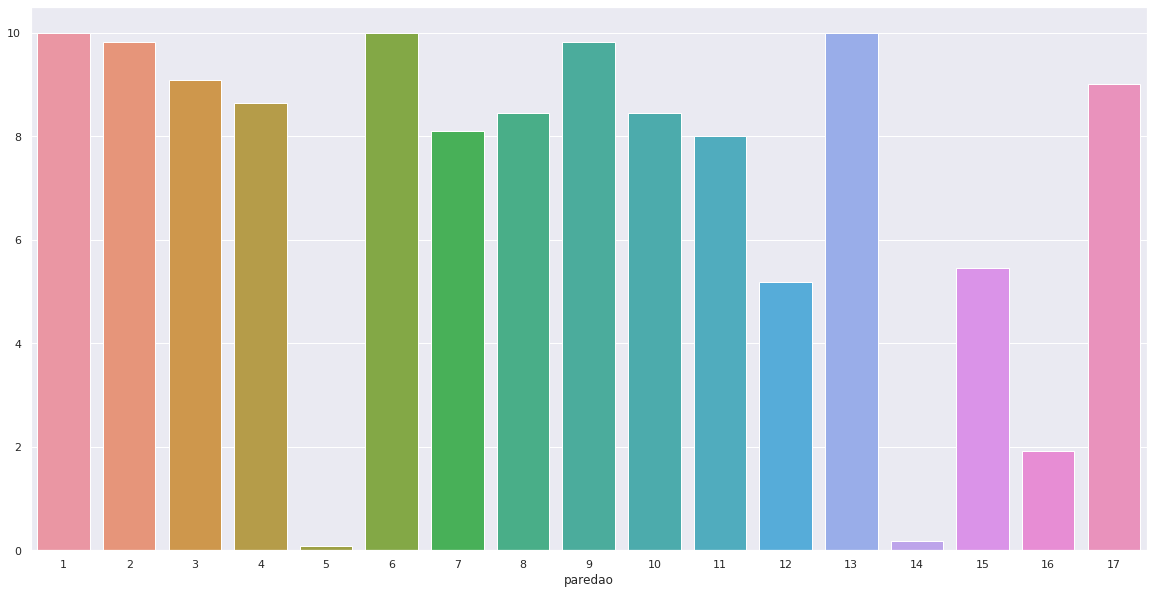

In [23]:
sns.barplot(x=paredoes_df.index, y=paredoes_df["correct"].values)